# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Quentin Talon, Albéric De Lajarte 
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

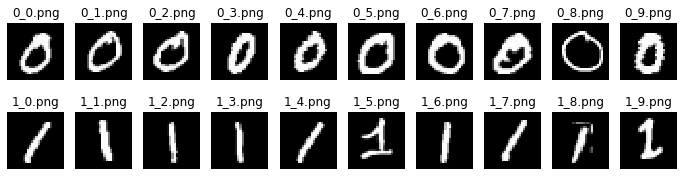

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2.1 Fourier descriptor
- We find a contour description of our object
- We create a vector containing it's (x,y) coordinates in form of (x+jy)
- We perform a Fourier Transform via the fft algorithm on our vector
- We select the Fourier coefficiants we want
- We show the amplitudes of a descriptor couple for *ones* and *zeros*

#### Why the amplitude ?
The Fourier transform is sensible to where we start the description of a loop.
$$ 
f_l = \sum_{k}x_k e^{-2\pi j\color{red}{k}l/N}
$$
It will change each $f_l$ phase. We can change the DFT to something that is independant of the starting description point OR look at the amplitude only.

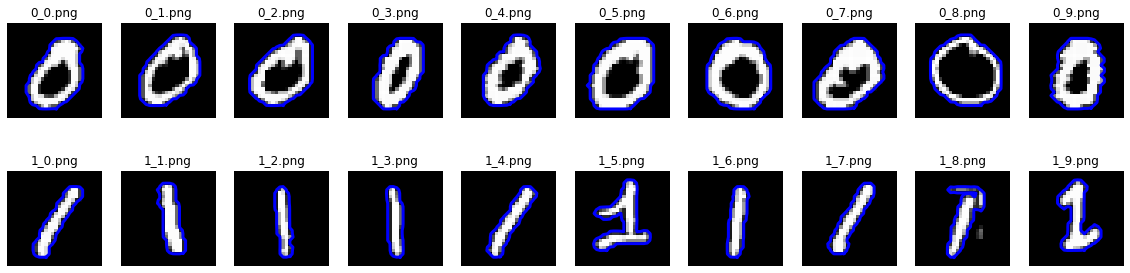

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.measure import find_contours
from skimage.segmentation import active_contour
from scipy import ndimage

zeros_contour = []
ones_contour = []

fig, axes = plt.subplots(2, len(zeros_im), figsize=(20, 5))
for ax, im, nm, k in zip(axes[0], zeros_im, zeros_names, np.arange(0, zeros_im.shape[0]) ):
    ax.imshow(im, cmap='gray')
    zeros_contour.append(find_contours(im, 10)[0])
    ax.plot(zeros_contour[k][:, 1], zeros_contour[k][:, 0], '-b', lw=3)
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm, k in zip(axes[1], ones_im, ones_names, np.arange(0, zeros_im.shape[0])):
    ax.imshow(im, cmap='gray')
    ones_contour.append(find_contours(im, 10)[0])
    ax.plot(ones_contour[k][:, 1], ones_contour[k][:, 0], '-b', lw=3)
    ax.axis('off')
    ax.set_title(nm)

We see that the contour nicely fit the images. This allow us to run the Fourier analysis on a 2D line rather than a 2D matrix:

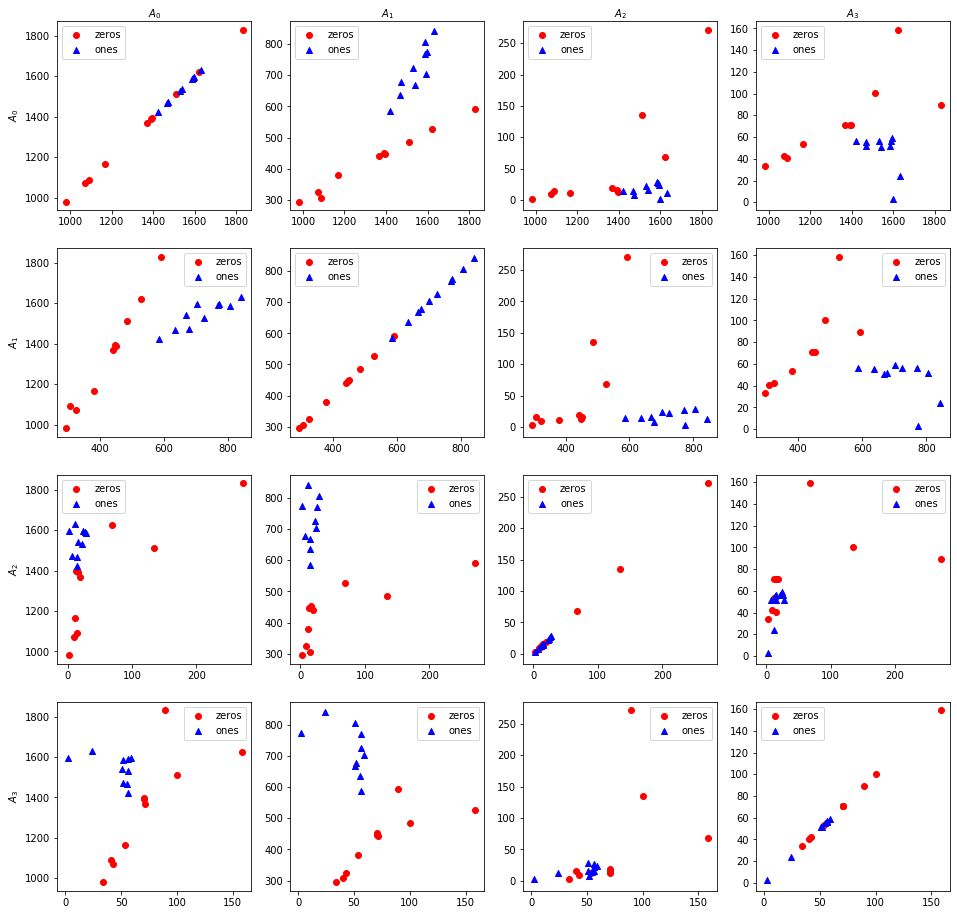

In [4]:
desc = np.array([0, 1, 2, 3]) #Which values from the Fourier Transform we want to keep

ones_complex = [[np.complex(x[1], x[0]) for x in X] for X in ones_contour[0:10]]
ones_FFT = [np.fft.fft(x)[desc] for x in ones_complex]

zeros_complex = [[np.complex(x[1], x[0]) for x in X] for X in zeros_contour[0:10]]
zeros_FFT = [np.fft.fft(x)[desc] for x in zeros_complex]

fig, axes = plt.subplots(len(desc), len(desc), figsize=(16, 16))#quadrillage de plot

for i, (di, axi) in enumerate(zip(desc, axes)):
    axi[0].set_ylabel("$A_{}$".format(di))
    for j, (dj, ax) in enumerate(zip(desc, axi)) :
        if(i == 0):
            ax.set_xlabel("$A_{}$".format(dj))
            ax.xaxis.set_label_position('top')
            #ax.xaxis.set_ticks_position('top')
        X = [abs(vec[i]) for vec in ones_FFT]
        Y = [abs(vec[j]) for vec in ones_FFT]
        ax.scatter(X,Y, color='red', marker="o", label = "zeros")
    
        X = [abs(vec[i]) for vec in zeros_FFT]
        Y = [abs(vec[j]) for vec in zeros_FFT]
        ax.scatter(X,Y, color='blue', marker="^", label = "ones")
    
        #ax.set_xlabel("$A_{}$".format(di))
        #ax.set_ylabel("$A_{}$".format(dj))
        ax.legend()
plt.show()

From this matrix, we see that it is quite easy to separate the ones from the zeros with only two features. Some of the Fourier descriptors combination, like ($A_{1}$, $A_{0}$) and ($A_{2}$, $A_{1}$) even allow for a simple linear classifier to distinguish them. 
Additionally, we can expect that a classification method using these descriptors could be invariant in rotation and translation, as using only the amplitude of the Fourier coefficient above $A_{0}$ seems to provide a sufficient description. This will be explored more in depth in part 1.3.3

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1.3.1 Fourier descriptor via binary image
- We simply create a binary image by setting an arbitrary treshold.
- We create a vector containing the (x,y) coordinates in form of (x+jy)
- We perform a Fourier Transform via the fft algorithm on our vector
- We select the Fourier coefficiants we want
- We show the real and imaginary parts of these Fourier coef. for *ones* and *zeros*

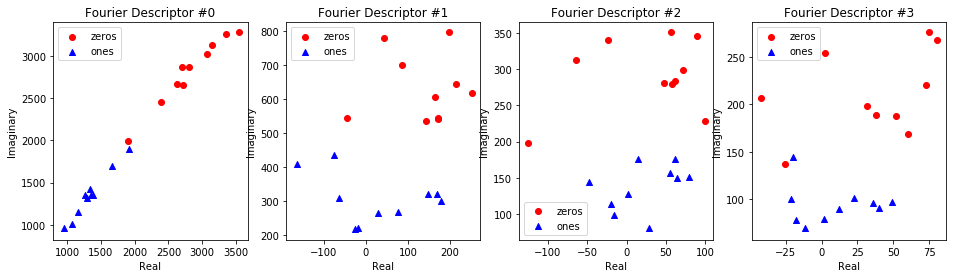

In [5]:
desc = [0, 1, 2, 3] #Which values from the Fourier Transform we want to keep
th=0.8 #Stupid treshold to get Binary image.

vecones_fd = [np.fft.fft([np.complex(i,j) for i, l in enumerate(np.where(x > th, 1, 0)) for j, c in enumerate(l) if c > 0])[desc] for x in ones_im[0:11]]
veczeros_fd = [np.fft.fft([np.complex(i,j) for i, l in enumerate(np.where(x > th, 1, 0)) for j, c in enumerate(l) if c > 0])[desc] for x in zeros_im[0:11]]

fig, axes = plt.subplots(1, len(desc), figsize=(16, 16/len(desc)))
for i, (d, ax) in enumerate(zip(desc, axes)):    
    X = [vec[i].real for vec in veczeros_fd]
    Y = [vec[i].imag for vec in veczeros_fd]
    ax.scatter(X,Y, color='red', marker="o", label = "zeros")
    
    X = [vec[i].real for vec in vecones_fd]
    Y = [vec[i].imag for vec in vecones_fd]
    ax.scatter(X,Y, color='blue', marker="^", label = "ones")
    
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    ax.set_title("Fourier Descriptor #{}".format(d))
    ax.legend()
plt.show()

The result is nice as we see clusters separated and regularity in different clusters. It takes less calculus to create the image but more calculus to compute the Fourier transform.

#### 1.3.2 Fourier descriptor via grayscale image

- We keep the grayscale image
- We create a vector containing the (x,y) coordinates in form of image(x,y)*(x+jy)
- We perform a Fourier Transform via the fft algorithm on our vector
- We select the Fourier coefficiants we want
- We show the real and imaginary parts of these Fourier coef. for *ones* and *zeros*

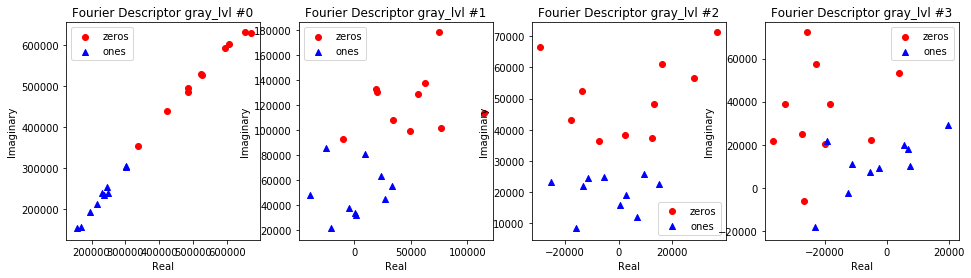

In [6]:
import numpy as np
desc = [0, 1, 2, 3] #Which values from the Fourier Transform we want to keep

vecones_fd_gray = [np.fft.fft([c*np.complex(i,j) for i, l in enumerate(x) for j, c in enumerate(l) if c > 0])[desc] for x in ones_im[0:11]]
veczeros_fd_gray = [np.fft.fft([c*np.complex(i,j) for i, l in enumerate(x) for j, c in enumerate(l) if c > 0])[desc] for x in zeros_im[0:11]]

fig, axes = plt.subplots(1, len(desc), figsize=(16, 16/len(desc)))
for i, (d, ax) in enumerate(zip(desc, axes)):    
    X = [vec[i].real for vec in veczeros_fd_gray]
    Y = [vec[i].imag for vec in veczeros_fd_gray]
    ax.scatter(X,Y, color='red', marker="o", label = "zeros")
    
    X = [vec[i].real for vec in vecones_fd_gray]
    Y = [vec[i].imag for vec in vecones_fd_gray]
    ax.scatter(X,Y, color='blue', marker="^", label = "ones")
    
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    ax.set_title("Fourier Descriptor gray_lvl #{}".format(d))
    ax.legend()
plt.show()

This was a bad idea since the beginning as multiplying the (x+iy) complex number by a value between 0 and 1 makes values an identical result as changing the coordinates. So we don't weight the descriptor, we change their meaning.

As we have few low value pixels, it doesn't affect much the output.

#### 1.3.3 Invariences (Translation, Scale, Rotation, Mirror)
**Translation**
We add a fixed value to each element of the contours.

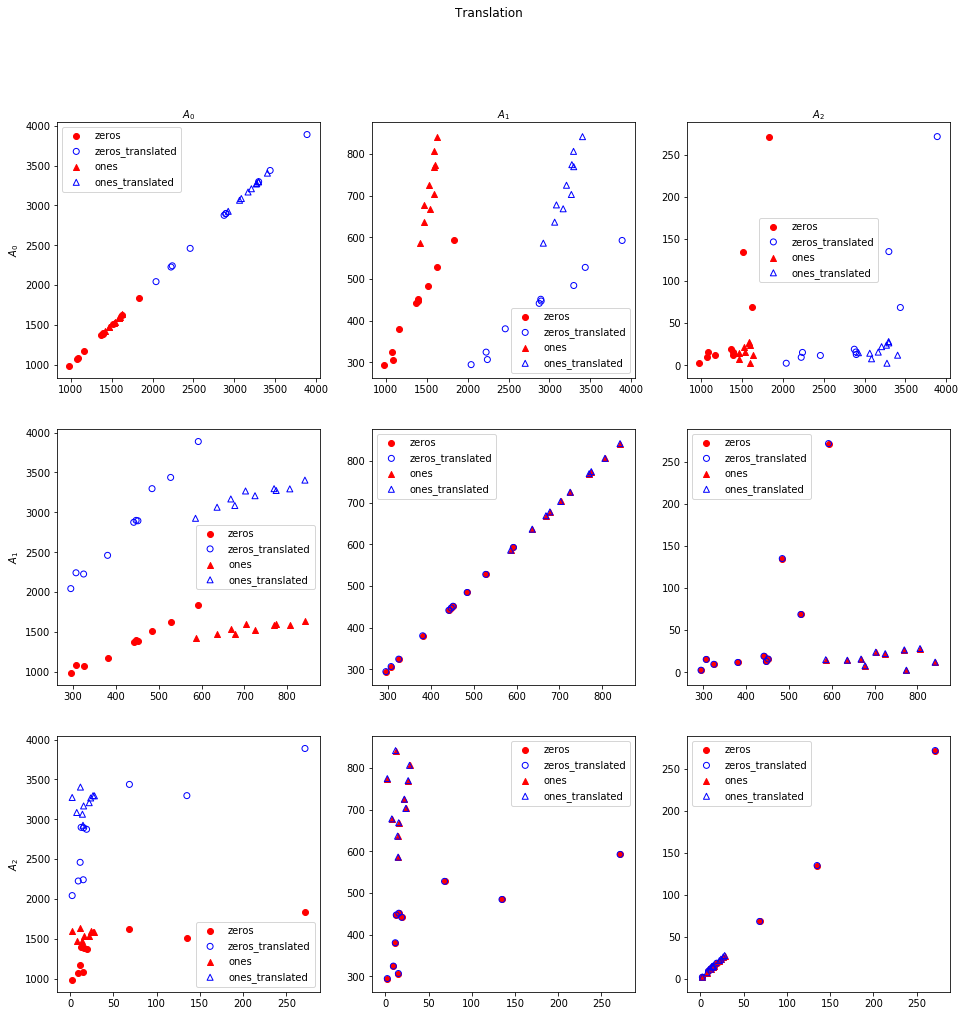

In [8]:
#plt.imshow(np.where(ones_im[0] > 0.8, 1, 0))
desc = np.array([0, 1, 2]) #Which values from the Fourier Transform we want to keep

ones_complex_special = [[x+np.complex(20,10) for x in one_complex] for one_complex in ones_complex]
ones_FFT_special = [np.fft.fft(one_complex_special)[desc] for one_complex_special in ones_complex_special]

zeros_complex_special = [[x+np.complex(20,10) for x in zeros_complex] for zeros_complex in zeros_complex]
zeros_FFT_special = [np.fft.fft(zero_complex_special)[desc] for zero_complex_special in zeros_complex_special]

fig, axes = plt.subplots(len(desc), len(desc), figsize=(16, 16))#quadrillage de plot

for i, (di, axi) in enumerate(zip(desc, axes)):
    axi[0].set_ylabel("$A_{}$".format(di))
    for j, (dj, ax) in enumerate(zip(desc, axi)) :
        if(i == 0):
            ax.set_xlabel("$A_{}$".format(dj))
            ax.xaxis.set_label_position('top')
            #ax.xaxis.set_ticks_position('top')
        X = [abs(vec[i]) for vec in ones_FFT]
        Y = [abs(vec[j]) for vec in ones_FFT]
        ax.scatter(X,Y, color='red', marker="o", label = "zeros")
        X = [abs(vec[i]) for vec in ones_FFT_special]
        Y = [abs(vec[j]) for vec in ones_FFT_special]
        ax.scatter(X,Y, color='blue', marker="o", facecolors='none', label = "zeros_translated")
        
        X = [abs(vec[i]) for vec in zeros_FFT]
        Y = [abs(vec[j]) for vec in zeros_FFT]
        ax.scatter(X,Y, color='red', marker="^", label = "ones")
        X = [abs(vec[i]) for vec in zeros_FFT_special]
        Y = [abs(vec[j]) for vec in zeros_FFT_special]
        ax.scatter(X,Y, color='blue', marker="^", facecolors='none', label = "ones_translated")
    
        #ax.set_xlabel("$A_{}$".format(di))
        #ax.set_ylabel("$A_{}$".format(dj))
        ax.legend()
        
fig.suptitle("Translation")
plt.show()

As expected, the shift disapered at higher Fourier Descriptors than $A_0$.

**Scale**  
We'll multiply every element of the contour by a factor.

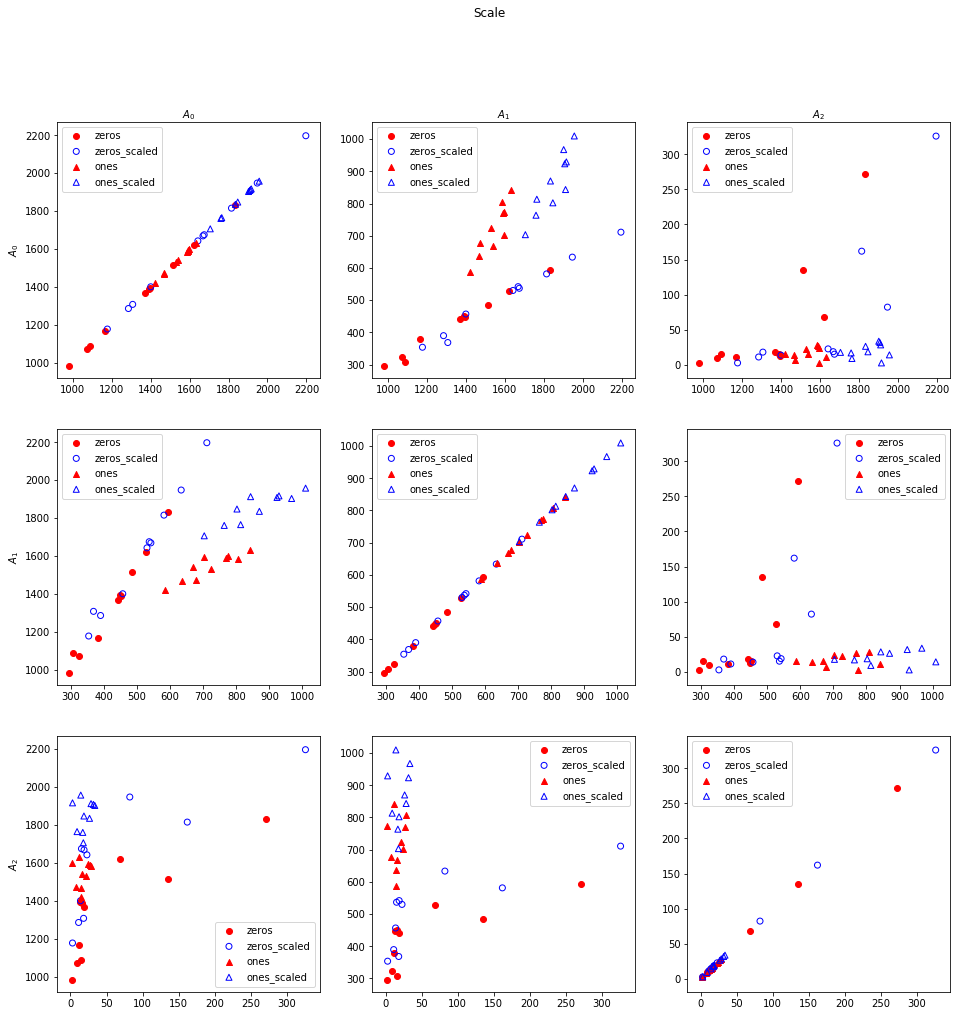

In [10]:
#plt.imshow(np.where(ones_im[0] > 0.8, 1, 0))
desc = np.array([0, 1, 2]) #Which values from the Fourier Transform we want to keep

ones_complex_special = [[x*1.2 for x in one_complex] for one_complex in ones_complex]
ones_FFT_special = [np.fft.fft(one_complex_special)[desc] for one_complex_special in ones_complex_special]

zeros_complex_special = [[x*1.2 for x in zeros_complex] for zeros_complex in zeros_complex]
zeros_FFT_special = [np.fft.fft(zero_complex_special)[desc] for zero_complex_special in zeros_complex_special]

fig, axes = plt.subplots(len(desc), len(desc), figsize=(16, 16))#quadrillage de plot

for i, (di, axi) in enumerate(zip(desc, axes)):
    axi[0].set_ylabel("$A_{}$".format(di))
    for j, (dj, ax) in enumerate(zip(desc, axi)) :
        if(i == 0):
            ax.set_xlabel("$A_{}$".format(dj))
            ax.xaxis.set_label_position('top')
            #ax.xaxis.set_ticks_position('top')
        X = [abs(vec[i]) for vec in ones_FFT]
        Y = [abs(vec[j]) for vec in ones_FFT]
        ax.scatter(X,Y, color='red', marker="o", label = "zeros")
        X = [abs(vec[i]) for vec in ones_FFT_special]
        Y = [abs(vec[j]) for vec in ones_FFT_special]
        ax.scatter(X,Y, color='blue', marker="o", facecolors='none', label = "zeros_scaled")
        
        X = [abs(vec[i]) for vec in zeros_FFT]
        Y = [abs(vec[j]) for vec in zeros_FFT]
        ax.scatter(X,Y, color='red', marker="^", label = "ones")
        X = [abs(vec[i]) for vec in zeros_FFT_special]
        Y = [abs(vec[j]) for vec in zeros_FFT_special]
        ax.scatter(X,Y, color='blue', marker="^", facecolors='none', label = "ones_scaled")
    
        #ax.set_xlabel("$A_{}$".format(di))
        #ax.set_ylabel("$A_{}$".format(dj))
        ax.legend()
fig.suptitle("Scale")
plt.show()

As axpected, the scale is not invarient.

**Rotation**  
We'll rotate the whole contour:
- Shift it to have the (0,0) point in the middle of the image
- Apply a rotation by multiplication by $e^{j\theta}$
- Shift it back to it's initial coordinates system.

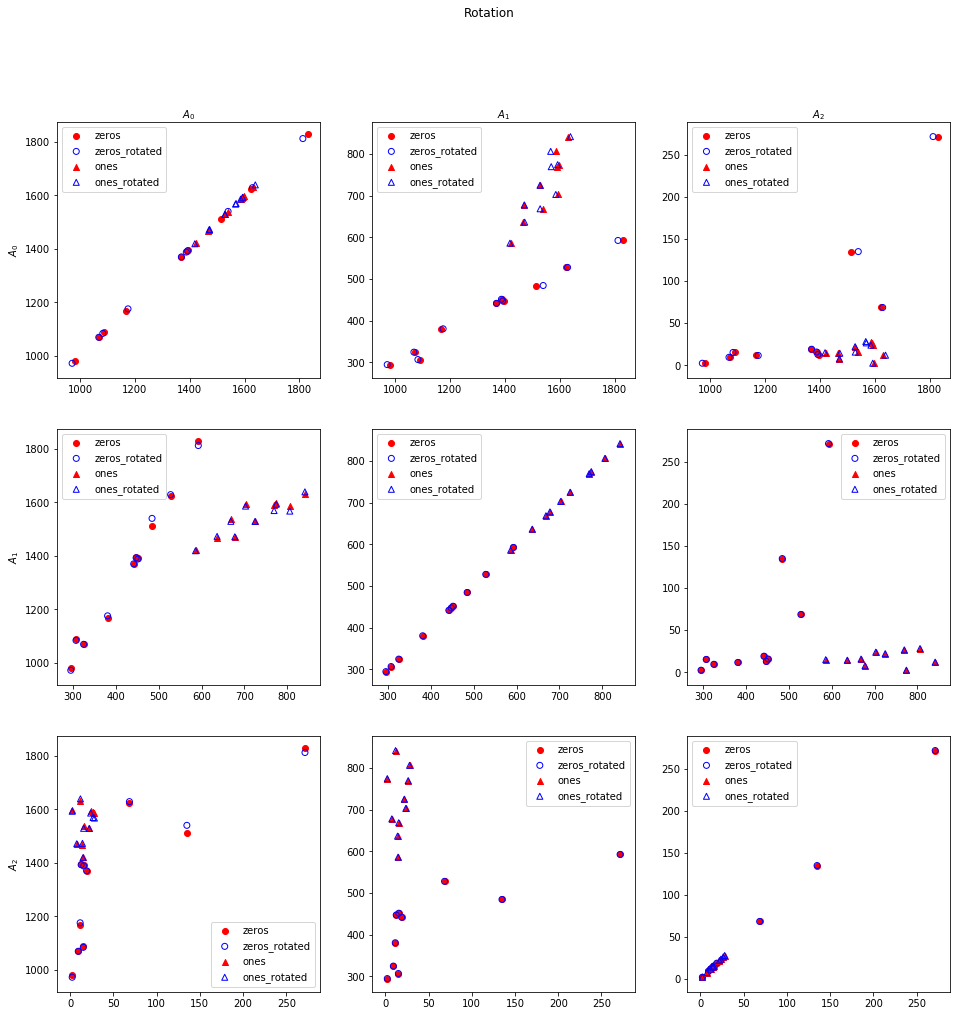

In [11]:
#plt.imshow(np.where(ones_im[0] > 0.8, 1, 0))
desc = np.array([0, 1, 2]) #Which values from the Fourier Transform we want to keep
im_shift=np.complex(ones_im[0].shape[0]/2,ones_im[0].shape[1]/2)
angle=0.23

ones_complex_special = [[np.exp(1j*angle)*(x-im_shift)+im_shift for x in one_complex] for one_complex in ones_complex]
ones_FFT_special = [np.fft.fft(one_complex_special)[desc] for one_complex_special in ones_complex_special]

zeros_complex_special = [[np.exp(1j*angle)*(x-im_shift)+im_shift for x in zeros_complex] for zeros_complex in zeros_complex]
zeros_FFT_special = [np.fft.fft(zero_complex_special)[desc] for zero_complex_special in zeros_complex_special]

fig, axes = plt.subplots(len(desc), len(desc), figsize=(16, 16))#quadrillage de plot

for i, (di, axi) in enumerate(zip(desc, axes)):
    axi[0].set_ylabel("$A_{}$".format(di))
    for j, (dj, ax) in enumerate(zip(desc, axi)) :
        if(i == 0):
            ax.set_xlabel("$A_{}$".format(dj))
            ax.xaxis.set_label_position('top')
            #ax.xaxis.set_ticks_position('top')
        X = [abs(vec[i]) for vec in ones_FFT]
        Y = [abs(vec[j]) for vec in ones_FFT]
        ax.scatter(X,Y, color='red', marker="o", label = "zeros")
        X = [abs(vec[i]) for vec in ones_FFT_special]
        Y = [abs(vec[j]) for vec in ones_FFT_special]
        ax.scatter(X,Y, color='blue', marker="o", facecolors='none', label = "zeros_rotated")
        
        X = [abs(vec[i]) for vec in zeros_FFT]
        Y = [abs(vec[j]) for vec in zeros_FFT]
        ax.scatter(X,Y, color='red', marker="^", label = "ones")
        X = [abs(vec[i]) for vec in zeros_FFT_special]
        Y = [abs(vec[j]) for vec in zeros_FFT_special]
        ax.scatter(X,Y, color='blue', marker="^", facecolors='none', label = "ones_rotated")
    
        #ax.set_xlabel("$A_{}$".format(di))
        #ax.set_ylabel("$A_{}$".format(dj))
        ax.legend()
        
fig.suptitle("Rotation")
plt.show()

As we plot the amplitudes in these graphs, $A_0$ should change as the rotation is around the center of the **image** and not around the center of the **contour**.  
$A_{k\neq 0}$ should not change.

Note that it could be interesting to have a non-rotation invarient way of clustering, as numbers are not rotation invarient. (Think about $8$ and $\infty$ or $1$ and $7$)

**Mirror**
We'll mirror on the horizontal axis the whole contour:
- Shift it to have the (0,0) point in the middle of the image
- Change the vector ordering
- Change the sign of the imaginary part
- Shift it back to it's initial coordinates system.

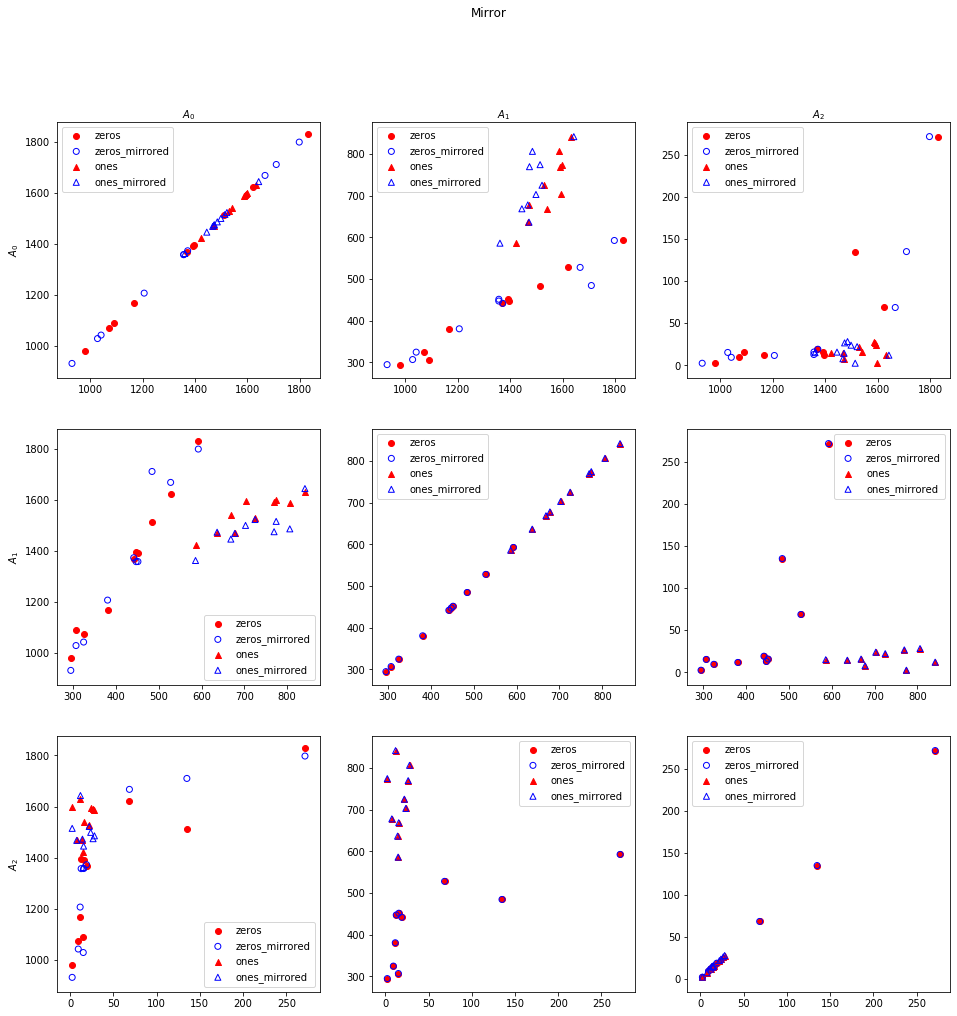

In [17]:
desc = np.array([0, 1, 2]) #Which values from the Fourier Transform we want to keep

ones_complex_special = [[np.conjugate(x-im_shift)+im_shift for x in one_complex[::-1]] for one_complex in ones_complex]
ones_FFT_special = [np.fft.fft(one_complex_special)[desc] for one_complex_special in ones_complex_special]

zeros_complex_special = [[np.conjugate(x-im_shift)+im_shift for x in zero_complex[::-1]] for zero_complex in zeros_complex]
zeros_FFT_special = [np.fft.fft(zero_complex_special)[desc] for zero_complex_special in zeros_complex_special]

fig, axes = plt.subplots(len(desc), len(desc), figsize=(16, 16))#quadrillage de plot

for i, (di, axi) in enumerate(zip(desc, axes)):
    axi[0].set_ylabel("$A_{}$".format(di))
    for j, (dj, ax) in enumerate(zip(desc, axi)) :
        if(i == 0):
            ax.set_xlabel("$A_{}$".format(dj))
            ax.xaxis.set_label_position('top')
            #ax.xaxis.set_ticks_position('top')
        X = [abs(vec[i]) for vec in ones_FFT]
        Y = [abs(vec[j]) for vec in ones_FFT]
        ax.scatter(X,Y, color='red', marker="o", label = "zeros")
        X = [abs(vec[i]) for vec in ones_FFT_special]
        Y = [abs(vec[j]) for vec in ones_FFT_special]
        ax.scatter(X,Y, color='blue', marker="o", facecolors='none', label = "zeros_mirrored")
        
        X = [abs(vec[i]) for vec in zeros_FFT]
        Y = [abs(vec[j]) for vec in zeros_FFT]
        ax.scatter(X,Y, color='red', marker="^", label = "ones")
        X = [abs(vec[i]) for vec in zeros_FFT_special]
        Y = [abs(vec[j]) for vec in zeros_FFT_special]
        ax.scatter(X,Y, color='blue', marker="^", facecolors='none', label = "ones_mirrored")
    
        #ax.set_xlabel("$A_{}$".format(di))
        #ax.set_ylabel("$A_{}$".format(dj))
        ax.legend()
        
fig.suptitle("Mirror")
plt.show()

The frequencies in a contour should be the same when mirrored.  
Except for $A_0$ as we might have a shift in the average. To proove this, think about $\top$ and $\perp$ symbols. They have their center shifted from one to the other.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

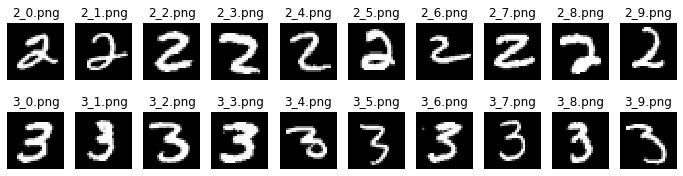

In [18]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

We use the same method as in part 1, which is to find the contour of each digit and plotting the amplitude of the first Fourier coefficient to check if they are enough for classification

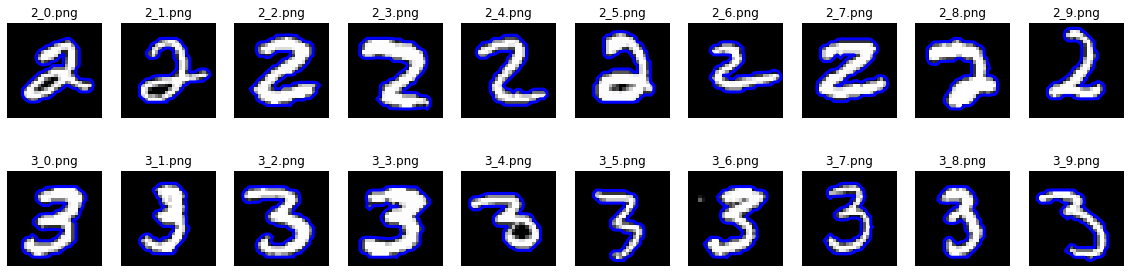

In [19]:
desc = [0, 1, 2, 3] #Which values from the Fourier Transform we want to keep

twos_contour = []
threes_contour = []
fig, axes = plt.subplots(2, len(twos_im), figsize=(20, 5))
for ax, im, nm, k in zip(axes[0], twos_im, twos_names, np.arange(0, twos_im.shape[0]) ):
    ax.imshow(im, cmap='gray')
    twos_contour.append(find_contours(im, 10)[0])
    ax.plot(twos_contour[k][:, 1], twos_contour[k][:, 0], '-b', lw=3)
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm, k in zip(axes[1], threes_im, threes_names, np.arange(0, threes_im.shape[0])):
    ax.imshow(im, cmap='gray')
    threes_contour.append(find_contours(im, 10)[0])
    ax.plot(threes_contour[k][:, 1], threes_contour[k][:, 0], '-b', lw=3)
    ax.axis('off')
    ax.set_title(nm)

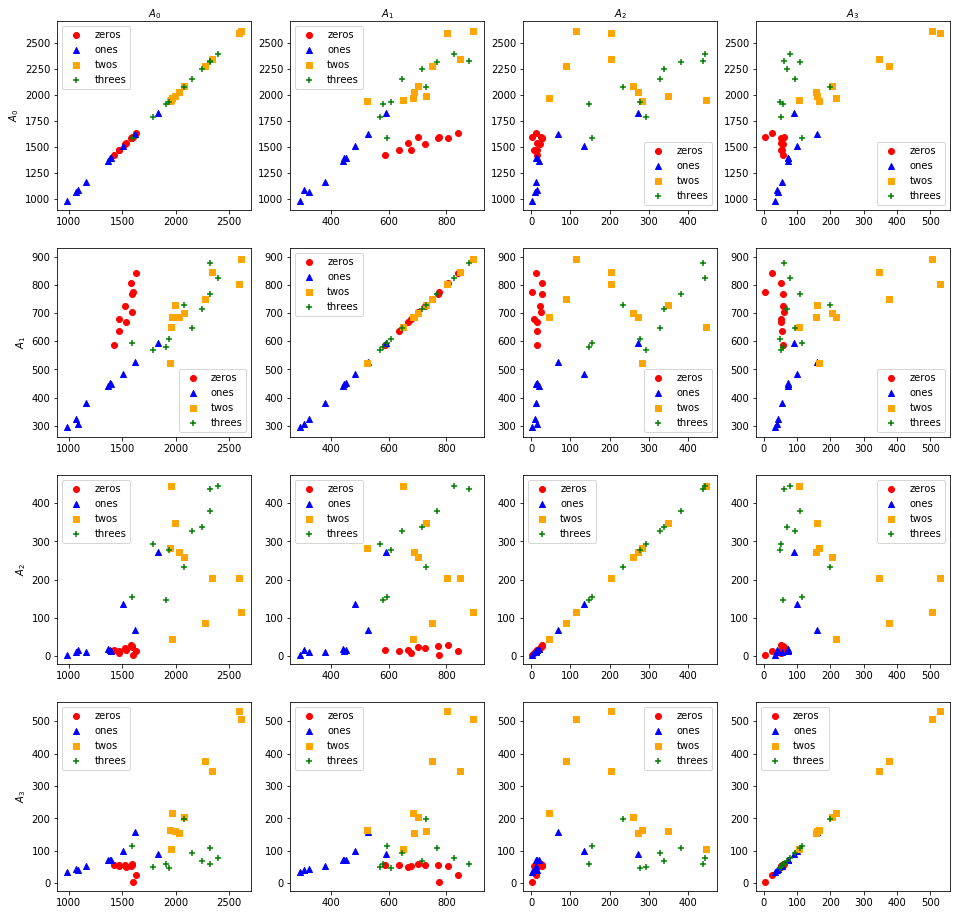

In [20]:
twos_complex = [[np.complex(x[1], x[0]) for x in X] for X in twos_contour[0:10]]
twos_FFT = [np.fft.fft(x)[desc] for x in twos_complex]

threes_complex = [[np.complex(x[1], x[0]) for x in X] for X in threes_contour[0:10]]
threes_FFT = [np.fft.fft(x)[desc] for x in threes_complex]

zeros = {"FFT":zeros_FFT,
         "name":"zeros",
       "marker":"o",
       "color":"red"}

ones = {"FFT":ones_FFT,
        "name":"ones",
       "marker":"^",
       "color":"blue"}

twos = {"FFT":twos_FFT,
        "name":"twos",
       "marker":"s",
       "color":"orange"}

threes = {"FFT":threes_FFT,
          "name":"threes",
       "marker":"+",
       "color":"green"}

datass = {"zeros":zeros, "ones":ones, "twos":twos, "threes":threes}

fig, axes = plt.subplots(len(desc), len(desc), figsize=(16, 16))#quadrillage de plot

for i, (di, axi) in enumerate(zip(desc, axes)):
    axi[0].set_ylabel("$A_{}$".format(di))
    for j, (dj, ax) in enumerate(zip(desc, axi)) :
        if(i == 0):
            ax.set_xlabel("$A_{}$".format(dj))
            ax.xaxis.set_label_position('top')            
        for x in datass:
            X = [abs(vec[j]) for vec in datass[x]["FFT"]]
            Y = [abs(vec[i]) for vec in datass[x]["FFT"]]
            ax.scatter(X, Y, color=datass[x]["color"], marker=datass[x]["marker"], label = datass[x]["name"])
        ax.legend()
plt.show()

One can see that with only 2d coordinates, it is not possible to discriminate these numbers.
However, in more dimentions, it seems to be possible to do so. The *ones* are near the *threes* in the $A_3$, $A_1$ plot. But they are far away in the the $A_2$, $A_1$ plot.  
Lets try to visulalise it with a 3d plot with $A_1$, $A_2$ and $A_3$ as coordinates.  
Note that this takes time (<5 minutes) to run as we generate many plots.

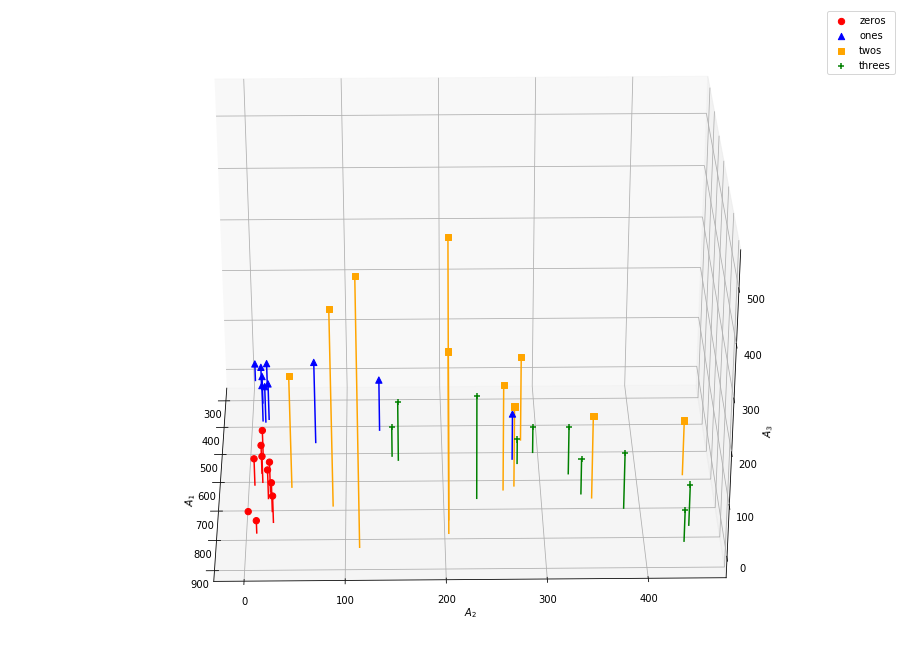

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
Ax=desc[1]
Ay=desc[2]
Az=desc[3]
for x in datass:
    X = [abs(vec[Ax]) for vec in datass[x]["FFT"]]
    Y = [abs(vec[Ay]) for vec in datass[x]["FFT"]]
    Z = [abs(vec[Az]) for vec in datass[x]["FFT"]]

    ax.scatter(X, Y, Z, s=40, alpha=1, color=datass[x]["color"], marker=datass[x]["marker"], label = datass[x]["name"])
    for xx,yy,zz in zip(X,Y,Z): ax.plot([xx,xx],[yy,yy],[0,zz], '-', color=datass[x]["color"])

ax.set_xlabel("$A_{}$".format(desc[Ax]))
ax.set_ylabel("$A_{}$".format(desc[Ay]))
ax.set_zlabel("$A_{}$".format(desc[Az]))
ax.legend()
if True:
    for ang in range(0,360):#[0, 20, 40, 80, 100, 120]:
        ax.view_init(30, ang)
        plt.savefig("angle_{:04d}.png".format(ang))


We convert images to a movie by using this code in bash :  
*ffmpeg -framerate 24 -pattern_type glob -i '&ast;.png' output.mp4*  

In [22]:
%%bash
ffmpeg -framerate 24 -pattern_type glob -i '*.png' -loglevel warning -y out.mp4 

Then, we visualise it to see if we have some clustering effects.

In [23]:
from IPython.display import Video

Video("out.mp4", width=1024, height=576)

We see that we have better clustering. We see clearly the *zeros*. The *ones* are packed, except one or two that goes with the